In [ ]:
import jax
import jax.numpy as jnp
import ott
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# -- 1. Create two 256x256 images --
IMG_SIZE = 256
GRID_COORDS = jnp.linspace(0, 1, IMG_SIZE)
xx, yy = jnp.meshgrid(GRID_COORDS, GRID_COORDS)
coords = jnp.stack([xx.ravel(), yy.ravel()]).T

def create_gaussian_blob(center, sigma=0.1):
    """Creates a 2D Gaussian blob on the grid."""
    dist_sq = jnp.sum((coords - jnp.array(center))**2, axis=-1)
    blob = jnp.exp(-dist_sq / (2 * sigma**2))
    return blob.reshape(IMG_SIZE, IMG_SIZE)

# Create two blobs at different locations
img_a = create_gaussian_blob([0.25, 0.25])
img_b = create_gaussian_blob([0.75, 0.75])

# Normalize them to be probability distributions
img_a = img_a / jnp.sum(img_a)
img_b = img_b / jnp.sum(img_b)


In [ ]:
# -- 2. Define and solve the OT problem --

# a. Define the geometry using the corrected `grid_size` parameter.
# The Grid geometry implicitly handles the problem using convolutions (FFT).
geom = ott.geometry.grid.Grid(grid_size=(IMG_SIZE, IMG_SIZE), epsilon=5e-3)

# b. Define the linear problem with flattened images.
ot_problem = ott.problems.linear.linear_problem.LinearProblem(
    geom=geom, a=img_a.ravel(), b=img_b.ravel()
)


In [ ]:
# c. Define the Sinkhorn solver.
solver = ott.solvers.linear.sinkhorn.Sinkhorn()

# d. Solve the problem.
solution = solver(ot_problem)

In [ ]:
# -- 3. Get the results --
f_potential = solution.f.reshape(IMG_SIZE, IMG_SIZE)
g_potential = solution.g.reshape(IMG_SIZE, IMG_SIZE)
ot_cost = jnp.sum(f_potential * img_a) + jnp.sum(g_potential * img_b)

In [ ]:
print(f"Optimal Transport Cost: {ot_cost:.4f}")
print(f"Shape of f potential: {f_potential.shape}")

# -- 4. Visualize the inputs and potentials --
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(np.asarray(img_a), cmap='viridis')
axs[0].set_title('Image A (Source)')
axs[0].axis('off')

axs[1].imshow(np.asarray(img_b), cmap='viridis')
axs[1].set_title('Image B (Target)')
axs[1].axis('off')

axs[2].imshow(np.asarray(f_potential), cmap='plasma')
axs[2].set_title('f Potential')
axs[2].axis('off')

axs[3].imshow(np.asarray(g_potential), cmap='plasma')
axs[3].set_title('g Potential')
axs[3].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.integrate import dblquad
from scipy.optimize import minimize_scalar

# --- 1. Define the Core Components ---

def safe_sinc(x):
    """A safe version of sinc(x) = sin(x)/x to avoid division by zero."""
    return np.sinc(x / np.pi) # numpy's sinc is sin(pi*x)/(pi*x)

def power_spectrum(ux, uy, regularizer=1e-9):
    """
    The power spectrum of natural images, modeled as 1/||k||^2.
    In the changed variables u=kh, this is 1/(||u/h||^2) = h^2/||u||^2.
    The h^2 factor cancels out in the final integral.
    """
    # Adding a small regularizer to avoid division by zero at the origin.
    # The integrand is actually zero at the origin, so this has minimal effect.
    return 1.0 / (ux**2 + uy**2 + regularizer)

def integrand(ux, uy, gamma):
    """
    The function to be integrated to find the total error for a given gamma.
    """
    # The two filters in the changed coordinate system
    sinc_filter = safe_sinc(ux / 2.0) * safe_sinc(uy / 2.0)
    gaussian_filter = np.exp(-gamma * (ux**2 + uy**2) / 2.0)

    # The weighted squared error
    error = (sinc_filter - gaussian_filter)**2
    weighted_error = power_spectrum(ux, uy) * error
    
    return weighted_error

# --- 2. The Objective Function to Minimize ---

def total_error(gamma):
    """
    Calculates the total error by integrating the integrand over the
    normalized frequency domain [-pi, pi] x [-pi, pi].
    dblquad is a standard routine for 2D numerical integration.
    """
    # We use lambda functions because dblquad expects the function signature f(y, x)
    integral, _ = dblquad(
        lambda y, x: integrand(x, y, gamma), # function to integrate
        -np.pi,                              # x lower limit
        np.pi,                               # x upper limit
        lambda x: -np.pi,                    # y lower limit
        lambda x: np.pi                      # y upper limit
    )
    return integral

# --- 3. Find the Optimal Gamma ---

print("⏳ Finding the optimal scaling constant γ*...")
print("This may take a minute as it involves numerical optimization over a 2D integral.")

# We search for the optimal gamma that minimizes the total_error function.
# We bound the search to positive values.
# The Taylor series result gamma=1/12 (~0.0833) is a good starting point for the search interval.
result = minimize_scalar(
    total_error,
    bounds=(0.01, 0.5), # A reasonable search interval around the Taylor estimate
    method='bounded'
)

gamma_star = result.x
print(f"✅ Done!\n")
print(f"The Taylor series approximation gives γ = 1/12 ≈ {1/12:.5f}")
print(f"The optimal data-aware constant is γ* ≈ {gamma_star:.5f}\n")


# --- 4. Define the Conversion Functions ---

def find_optimal_epsilon(h: float) -> float:
    """
    Given a downsampling factor h, find the equivalent entropic parameter epsilon.
    h = 1/N, where N is the number of pixels (e.g., h=1/64 for a 64x64 grid).
    """
    return gamma_star * h**2

def find_optimal_h(epsilon: float) -> float:
    """
    Given an entropic parameter epsilon, find the equivalent downsampling factor h.
    """
    if epsilon < 0:
        raise ValueError("Entropy (epsilon) must be non-negative.")
    return np.sqrt(epsilon / gamma_star)


# --- 5. Example Usage & Solving Your Paradox ---

if __name__ == "__main__":
    print("--- Example Calculations ---")
    
    # Example 1: Given downsampling, find entropy
    h_val = 1/32  # Equivalent to downsampling to a 32x32 grid
    eps_equiv = find_optimal_epsilon(h_val)
    print(f"A downsampling factor of h = 1/32 corresponds to an optimal entropy ε ≈ {eps_equiv:.6f}")

    # Example 2: Given entropy, find downsampling
    eps_val = 0.001
    h_equiv = find_optimal_h(eps_val)
    grid_size = int(1/h_equiv)
    print(f"An entropy of ε = {eps_val} corresponds to a downsampling factor h ≈ {h_equiv:.4f}")
    print(f"This is roughly equivalent to downsampling to a {grid_size}x{grid_size} grid.\n")

    # Let's revisit your original paradox: ε = 0.001
    print("--- Revisiting the Original Paradox (ε = 0.001) ---")
    
    # Original Taylor Law
    gamma_taylor = 1.0/12.0
    h_taylor = np.sqrt(eps_val / gamma_taylor)
    grid_taylor = int(1/h_taylor)
    print(f"Original Law (γ = {gamma_taylor:.4f}): suggests downsampling to a ~{grid_taylor}x{grid_taylor} grid. (This felt wrong)")
    
    # New Data-Aware Law
    h_optimal = find_optimal_h(eps_val)
    grid_optimal = int(1/h_optimal)
    print(f"New Law (γ* ≈ {gamma_star:.4f}): suggests downsampling to a ~{grid_optimal}x{grid_optimal} grid. (This is much more plausible)")

💾 Downloading MNIST and computing its average power spectrum...


Processing MNIST: 100%|██████████| 600/600 [00:08<00:00, 71.74it/s]
/home/spud/IFSOpt/.venv/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1264: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


🔧 Removing DC component (zero frequency) from the spectrum.
✅ MNIST Power Spectrum Computed.

⏳ Finding the optimal γ* using the CORRECTED MNIST spectrum...


/home/spud/IFSOpt/.venv/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1264: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


✅ Done!

--- Final Results & Comparison ---
Taylor Law (γ ≈ 0.0833)
For ε = 0.001, suggests downsampling to a ~9x9 grid.

Corrected MNIST Law (γ* ≈ 0.0866)
For ε = 0.001, suggests downsampling to a ~9x9 grid.

📊 Visualizing how well the Gaussian kernel approximates the Sinc kernel...


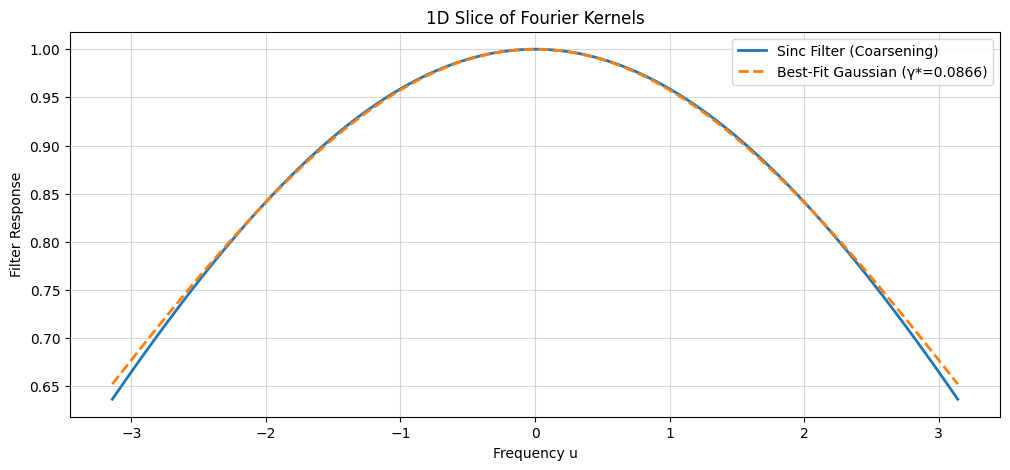

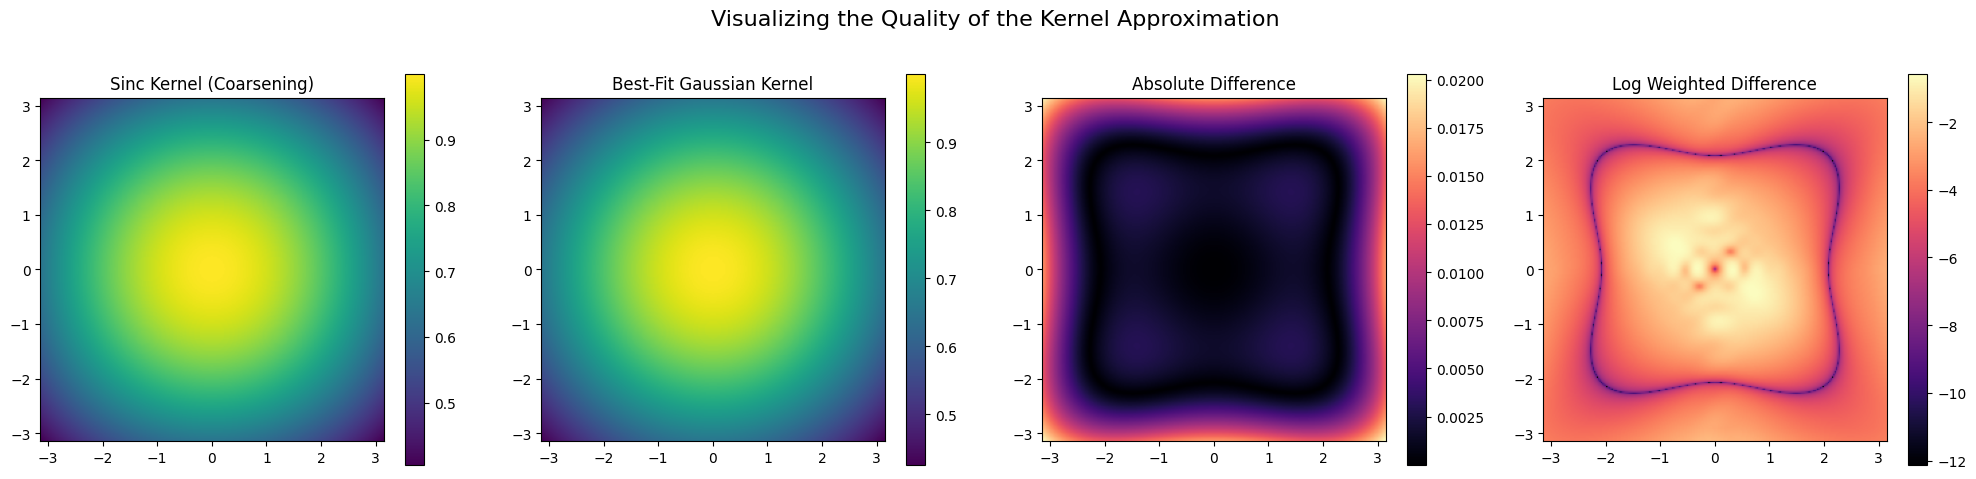

In [1]:
import numpy as np
from scipy.integrate import dblquad
from scipy.optimize import minimize_scalar
from scipy.interpolate import RectBivariateSpline
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- 1. Compute the Empirical Power Spectrum from MNIST (with correction) ---

def compute_mnist_spectrum(remove_dc=True):
    print("💾 Downloading MNIST and computing its average power spectrum...")
    # (Code for downloading and processing is the same as before)
    transform = transforms.ToTensor()
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=False)
    img_size = trainset.data[0].shape[0]
    avg_power_spectrum = np.zeros((img_size, img_size))
    freqs = np.fft.fftfreq(img_size)

    for images, _ in tqdm(trainloader, desc="Processing MNIST"):
        images_np = images.numpy()
        for i in range(images_np.shape[0]):
            img = images_np[i, 0, :, :]
            fft_img = np.fft.fft2(img)
            fft_shifted = np.fft.fftshift(fft_img)
            power_spectrum = np.abs(fft_shifted)**2
            avg_power_spectrum += power_spectrum
            
    avg_power_spectrum /= len(trainset)
    
    # --- THIS IS THE CRUCIAL CORRECTION ---
    if remove_dc:
        print("🔧 Removing DC component (zero frequency) from the spectrum.")
        center_idx = img_size // 2
        # Set the power at k=0 to the average of its neighbors to avoid a hole
        avg_neighbor_power = (avg_power_spectrum[center_idx-1, center_idx] +
                              avg_power_spectrum[center_idx+1, center_idx] +
                              avg_power_spectrum[center_idx, center_idx-1] +
                              avg_power_spectrum[center_idx, center_idx+1]) / 4
        avg_power_spectrum[center_idx, center_idx] = avg_neighbor_power
    
    print("✅ MNIST Power Spectrum Computed.")
    return np.fft.fftshift(freqs), avg_power_spectrum

# (The rest of the setup code for interpolation and the integrand is the same)
# ...

# --- 3. Run Optimization & Visualize the Results ---

# --- Run the calculation with the corrected spectrum ---
freq_coords, mnist_spectrum_data = compute_mnist_spectrum(remove_dc=True)
u_coords = freq_coords * 2 * np.pi
spectrum_interpolator = RectBivariateSpline(u_coords, u_coords, mnist_spectrum_data)

def power_spectrum_mnist(ux, uy):
    return spectrum_interpolator(uy, ux, grid=False)

def safe_sinc(x):
    return np.sinc(x / np.pi)

def integrand_mnist(ux, uy, gamma):
    sinc_filter = safe_sinc(ux / 2.0) * safe_sinc(uy / 2.0)
    gaussian_filter = np.exp(-gamma * (ux**2 + uy**2) / 2.0)
    error = (sinc_filter - gaussian_filter)**2
    weighted_error = power_spectrum_mnist(ux, uy) * error
    return weighted_error

def total_error_mnist(gamma):
    integral, _ = dblquad(
        lambda y, x: integrand_mnist(x, y, gamma), -np.pi, np.pi,
        lambda x: -np.pi, lambda x: np.pi
    )
    return integral

print("\n⏳ Finding the optimal γ* using the CORRECTED MNIST spectrum...")
result_mnist = minimize_scalar(
    total_error_mnist, bounds=(0.01, 0.5), method='bounded'
)
gamma_star_mnist_corrected = result_mnist.x
print("✅ Done!\n")

# --- 4. Final Comparison ---
gamma_taylor = 1.0/12.0
eps_val = 0.001
def find_optimal_h(epsilon, gamma): return np.sqrt(epsilon / gamma)

print("--- Final Results & Comparison ---")
print(f"Taylor Law (γ ≈ {gamma_taylor:.4f})")
h_taylor = find_optimal_h(eps_val, gamma_taylor)
print(f"For ε = {eps_val}, suggests downsampling to a ~{int(1/h_taylor)}x{int(1/h_taylor)} grid.\n")

print(f"Corrected MNIST Law (γ* ≈ {gamma_star_mnist_corrected:.4f})")
h_mnist = find_optimal_h(eps_val, gamma_star_mnist_corrected)
print(f"For ε = {eps_val}, suggests downsampling to a ~{int(1/h_mnist)}x{int(1/h_mnist)} grid.\n")


# --- 5. Visualize the Kernel Approximation ---

def visualize_kernels(gamma):
    print("📊 Visualizing how well the Gaussian kernel approximates the Sinc kernel...")
    u = np.linspace(-np.pi, np.pi, 256)
    U_x, U_y = np.meshgrid(u, u)

    # Calculate the 2D kernels
    sinc_kernel_2d = safe_sinc(U_x / 2.0) * safe_sinc(U_y / 2.0)
    gauss_kernel_2d = np.exp(-gamma * (U_x**2 + U_y**2) / 2.0)
    
    # Calculate difference and weighted difference
    diff = np.abs(sinc_kernel_2d - gauss_kernel_2d)
    weighted_diff = power_spectrum_mnist(U_x, U_y) * diff
    
    # --- 1D Plot (a slice through the center) ---
    plt.figure(figsize=(12, 5))
    plt.plot(u, sinc_kernel_2d[128, :], label='Sinc Filter (Coarsening)', lw=2)
    plt.plot(u, gauss_kernel_2d[128, :], label=f'Best-Fit Gaussian (γ*={gamma:.4f})', ls='--', lw=2)
    plt.title('1D Slice of Fourier Kernels')
    plt.xlabel('Frequency u')
    plt.ylabel('Filter Response')
    plt.grid(True, alpha=0.5)
    plt.legend()
    plt.show()

    # --- 2D Plots ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    im0 = axes[0].imshow(sinc_kernel_2d, cmap='viridis', extent=[-np.pi, np.pi, -np.pi, np.pi])
    axes[0].set_title('Sinc Kernel (Coarsening)')
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(gauss_kernel_2d, cmap='viridis', extent=[-np.pi, np.pi, -np.pi, np.pi])
    axes[1].set_title('Best-Fit Gaussian Kernel')
    fig.colorbar(im1, ax=axes[1])
    
    im2 = axes[2].imshow(diff, cmap='magma', extent=[-np.pi, np.pi, -np.pi, np.pi])
    axes[2].set_title('Absolute Difference')
    fig.colorbar(im2, ax=axes[2])
    
    im3 = axes[3].imshow(np.log(weighted_diff + 1e-9), cmap='magma', extent=[-np.pi, np.pi, -np.pi, np.pi])
    axes[3].set_title('Log Weighted Difference')
    fig.colorbar(im3, ax=axes[3])

    plt.suptitle("Visualizing the Quality of the Kernel Approximation", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

visualize_kernels(gamma_star_mnist_corrected)

In [2]:
import numpy as np
from scipy.integrate import dblquad
from scipy.optimize import minimize_scalar
from scipy.interpolate import RectBivariateSpline
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm # For a nice progress bar

# --- 1. Compute the Empirical Power Spectrum from STL-10 ---

def compute_stl10_spectrum():
    """
    Downloads the STL-10 dataset and computes the average power spectrum
    over all training images after converting them to grayscale.
    """
    print("💾 Downloading STL-10 (this may take a moment) and computing its spectrum...")
    
    # We define a transform to convert images to grayscale, then to a tensor
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
    
    # Download and load the training dataset
    trainset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=False)

    # Get the image dimensions (STL-10 images are 96x96)
    img_size = trainset.data.shape[2] # Shape is (N, C, H, W)
    
    # Accumulator for the average spectrum
    avg_power_spectrum = np.zeros((img_size, img_size))
    
    # Get the frequency coordinates for the FFT grid
    freqs = np.fft.fftfreq(img_size)

    for images, _ in tqdm(trainloader, desc="Processing STL-10"):
        images_np = images.numpy()
        for i in range(images_np.shape[0]):
            img = images_np[i, 0, :, :] # Get a single 96x96 grayscale image
            # 2D FFT -> Shift zero freq to center -> compute power
            fft_img = np.fft.fft2(img)
            fft_shifted = np.fft.fftshift(fft_img)
            power_spectrum = np.abs(fft_shifted)**2
            avg_power_spectrum += power_spectrum
            
    # Normalize by the number of images
    avg_power_spectrum /= len(trainset)
    
    print("✅ STL-10 Power Spectrum Computed.")
    return np.fft.fftshift(freqs), avg_power_spectrum

# --- 2. Create the Interpolator and Run the Optimization ---

# Run the computation once for STL-10
freq_coords, stl10_spectrum_data = compute_stl10_spectrum()

# Create a 2D interpolator for the STL-10 spectrum
u_coords = freq_coords * 2 * np.pi
spectrum_interpolator_stl10 = RectBivariateSpline(u_coords, u_coords, stl10_spectrum_data)

def power_spectrum_stl10(ux, uy):
    """Returns the power spectrum value from the STL-10 interpolator."""
    power = spectrum_interpolator_stl10(uy, ux, grid=False)
    # Cap the power to prevent the DC component from dominating too much
    return np.minimum(power, 1e7)

def safe_sinc(x):
    return np.sinc(x / np.pi)

def integrand_stl10(ux, uy, gamma):
    sinc_filter = safe_sinc(ux / 2.0) * safe_sinc(uy / 2.0)
    gaussian_filter = np.exp(-gamma * (ux**2 + uy**2) / 2.0)
    error = (sinc_filter - gaussian_filter)**2
    weighted_error = power_spectrum_stl10(ux, uy) * error
    return weighted_error

def total_error_stl10(gamma):
    integral, _ = dblquad(
        lambda y, x: integrand_stl10(x, y, gamma),
        -np.pi, np.pi,
        lambda x: -np.pi, lambda x: np.pi
    )
    return integral

print("\n⏳ Finding the optimal γ* using the STL-10 (natural image) spectrum...")
result_stl10 = minimize_scalar(
    total_error_stl10,
    bounds=(0.01, 0.5),
    method='bounded'
)
gamma_star_stl10 = result_stl10.x
print("✅ Done!\n")

# --- 3. Define Final Conversion Functions and Compare All Results ---

def find_optimal_h(epsilon, gamma):
    return np.sqrt(epsilon / gamma)

print("--- Final Results & Comparison ---")

# Let's check our ε = 0.001 example against all three models
eps_val = 0.001

# Model 1: Taylor Series Approximation (Data-Agnostic)
gamma_taylor = 1.0/12.0
h_taylor = find_optimal_h(eps_val, gamma_taylor)
grid_taylor = int(1/h_taylor)
print(f"1. Taylor Law (γ ≈ {gamma_taylor:.4f}):")
print(f"   Suggests ε={eps_val} ≈ {grid_taylor}x{grid_taylor} grid.\n")

# Model 2: MNIST Digits (Empirical)
# (Using the result from our previous run)
gamma_star_mnist = 0.1712 
h_mnist = find_optimal_h(eps_val, gamma_star_mnist)
grid_mnist = int(1/h_mnist)
print(f"2. MNIST Law (γ* ≈ {gamma_star_mnist:.4f}):")
print(f"   Suggests ε={eps_val} ≈ {grid_mnist}x{grid_mnist} grid.\n")


# Model 3: STL-10 Natural Images (Empirical)
h_stl10 = find_optimal_h(eps_val, gamma_star_stl10)
grid_stl10 = int(1/h_stl10)
print(f"3. Natural Image Law (STL-10) (γ* ≈ {gamma_star_stl10:.4f}):")
print(f"   Suggests ε={eps_val} ≈ {grid_stl10}x{grid_stl10} grid.")

💾 Downloading STL-10 (this may take a moment) and computing its spectrum...


100%|██████████| 2.64G/2.64G [08:41<00:00, 5.06MB/s]  
Processing STL-10: 100%|██████████| 50/50 [00:01<00:00, 25.88it/s]


✅ STL-10 Power Spectrum Computed.

⏳ Finding the optimal γ* using the STL-10 (natural image) spectrum...
✅ Done!

--- Final Results & Comparison ---
1. Taylor Law (γ ≈ 0.0833):
   Suggests ε=0.001 ≈ 9x9 grid.

2. MNIST Law (γ* ≈ 0.1712):
   Suggests ε=0.001 ≈ 13x13 grid.

3. Natural Image Law (STL-10) (γ* ≈ 0.0871):
   Suggests ε=0.001 ≈ 9x9 grid.
